In [22]:
# Gain modulation RNN with oja learning on weight matrix
import numpy as np
import sys
sys.path.append("..")
from rnn_sin2 import RNN
import matplotlib.pyplot as plt
import json
import torch
import seaborn as sns

In [1]:
import os
os.path.join("weight", "file")

'weight/file'

## Loading Trained Weights

In [23]:
with open('../weights/SIN2_bphcppt_32_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [24]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'weights', 'gains', 'shifts', 'activations', 'gain_changes', 'shift_changes', 'init_weight', 'init_activations'])

In [25]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])
gain_changes = np.array(weight_history['gain_changes'])
shift_changes = np.array(weight_history['shift_changes'])
init_weight_matrix = np.array(weight_history['init_weight'])
weights = weight_history['weights']
init_activations = np.array(weight_history['init_activations'])
simu_gains = np.array(weight_history['gains'])
simu_shifts = np.array(weight_history['shifts'])
simu_activations = np.array(weight_history['activations'])

In [27]:
sns.heatmap(np.array(weights[100]), vmax=2, vmin=-2, cmap='vlag')

IndexError: list index out of range

In [28]:
output_weight_matrix

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.]])

In [29]:
weight_matrix

array([[ 0.        ,  0.83669353,  0.83669353, ..., -0.75604838,
        -0.75604838, -0.75604838],
       [ 0.83669353,  0.        ,  0.83669353, ..., -0.75604838,
        -0.75604838, -0.75604838],
       [ 0.83669353,  0.83669353,  0.        , ..., -0.75604838,
        -0.75604838, -0.75604838],
       ...,
       [ 0.83669353,  0.83669353,  0.83669353, ..., -0.        ,
        -0.75604838, -0.75604838],
       [ 0.83669353,  0.83669353,  0.83669353, ..., -0.75604838,
        -0.        , -0.75604838],
       [ 0.83669353,  0.83669353,  0.83669353, ..., -0.75604838,
        -0.75604838, -0.        ]])

Text(0.5, 1.0, 'Weight matrix')

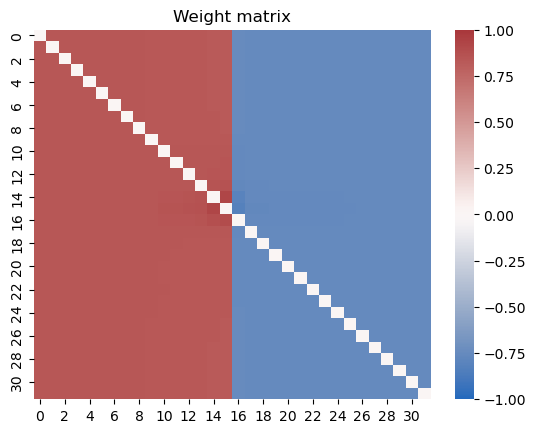

In [8]:
sns.heatmap(weight_matrix, vmax=1, vmin=-1, cmap='vlag')
plt.title('Weight matrix')
# plt.savefig('fig/0221_SIN2_bphcppt_weight_matrix.png')

## Defining Network

In [30]:
time_constant = 100 #ms
timestep = 10 #ms
ndata = 800
time = ndata * timestep #ms
num_inputs = 1
num_nodes = 32
# init_activations = np.zeros((num_nodes, 1))

100%|██████████| 800/800 [00:00<00:00, 12169.18it/s]


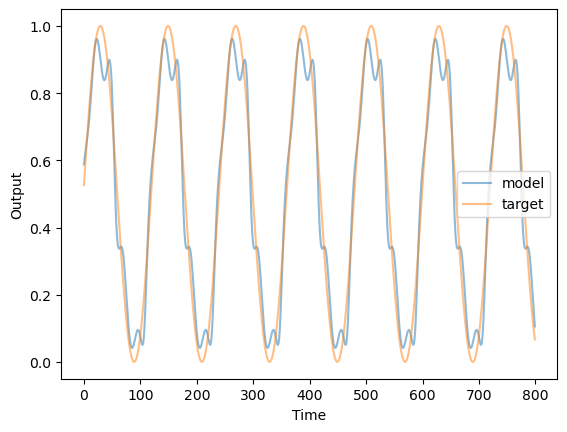

In [31]:
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

network = RNN(weight_matrix, connectivity_matrix, init_activations, gains, shifts, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)
outputs, activations = network.simulate(time, torch.tensor(inputs).float())

fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(time_points, targets, alpha=0.5, label='target')
# plt.ylim([0,1])
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
# plt.savefig("fig/0122_SIN2_bphebbpt_output.png")

Text(0.5, 1.0, 'Responses of Input Neurons')

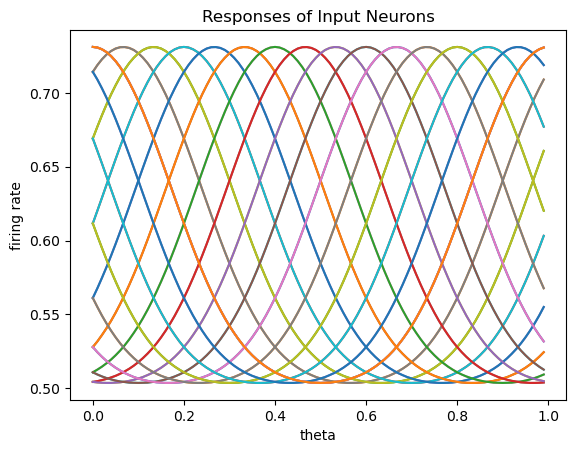

In [32]:
rates = []
for x in np.arange(0,1,0.01):
    input = network.input_gaussian(x)
    rate = network.activation_func(input)
    rates.append(rate)
rates = torch.cat(rates, dim=1)
rates = rates.detach().numpy().round(4)

for i in np.arange(0,rates.shape[0]):
    thisr = rates[i,:]
    plt.plot(np.arange(0,1,0.01), thisr)
plt.xlabel("theta")
plt.ylabel("firing rate")
plt.title("Responses of Input Neurons")

Text(0.5, 1.0, 'Responses of Input Neurons')

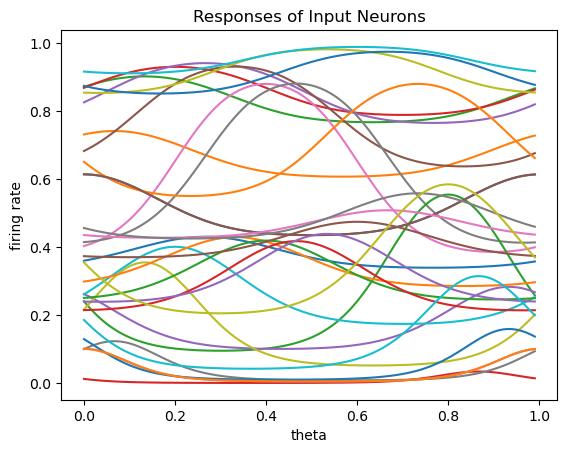

In [33]:
rates = []
for x in np.arange(0,1,0.01):
    input = network.input_gaussian(x)
    rate = network.activation_func(network.gain * (input - network.shift))
    rates.append(rate)
rates = torch.cat(rates, dim=1)
rates = rates.detach().numpy().round(4)

for i in np.arange(0,rates.shape[0]):
    thisr = rates[i,:]
    plt.plot(np.arange(0,1,0.01), thisr)
plt.xlabel("theta")
plt.ylabel("firing rate")
plt.title("Responses of Input Neurons")

100%|██████████| 800/800 [00:00<00:00, 12686.71it/s]


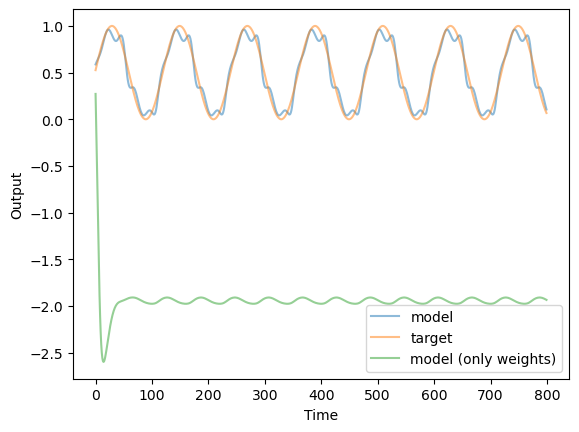

In [34]:
init_gains = np.ones((num_nodes, 1))
init_shifts = np.zeros((num_nodes, 1))
network = RNN(weight_matrix, connectivity_matrix, init_activations, init_gains, init_shifts, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)
outputs_wt, activations_wt = network.simulate(time, torch.tensor(inputs).float())

fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(time_points, targets, alpha=0.5, label='target')
plt.plot(time_points, outputs_wt.detach().numpy(), alpha=0.5, label='model (only weights)')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
# plt.savefig("fig/0221_SIN2_bphcppt_output.png")

Text(50.722222222222214, 0.5, 'Node')

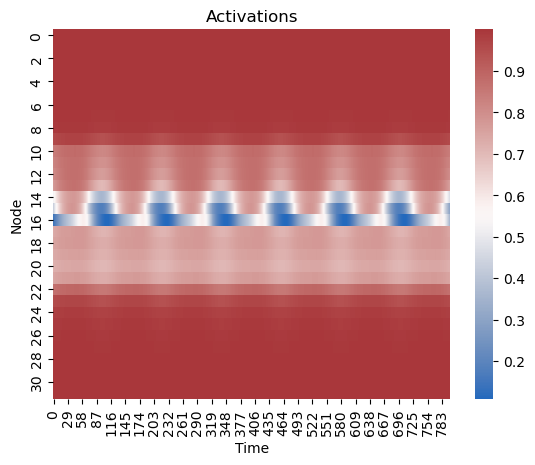

In [79]:
activations_t = activations.detach().numpy().T
sns.heatmap(activations_t, cmap='vlag')
plt.title('Activations')
plt.xlabel('Time')
plt.ylabel('Node')
# plt.savefig('fig/0221_SIN2_bphcppt_activations.png')

Text(0.5, 1.0, 'Training Loss over Epochs')

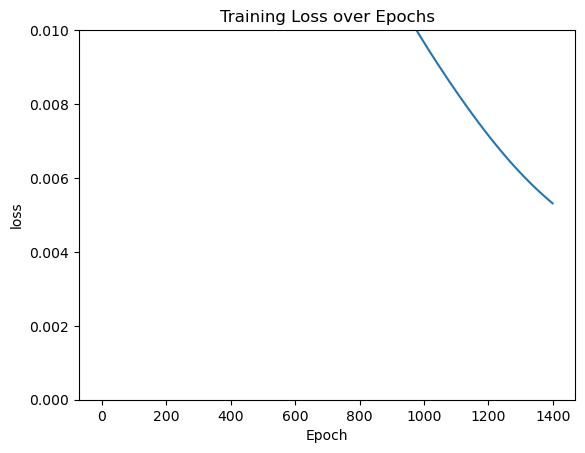

In [35]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.ylim([0,0.01])
plt.title("Training Loss over Epochs")
# plt.savefig("fig/0221_SIN2_bphcppt_loss.png")

Text(0.5, 1.0, 'Gain Changes over Epochs')

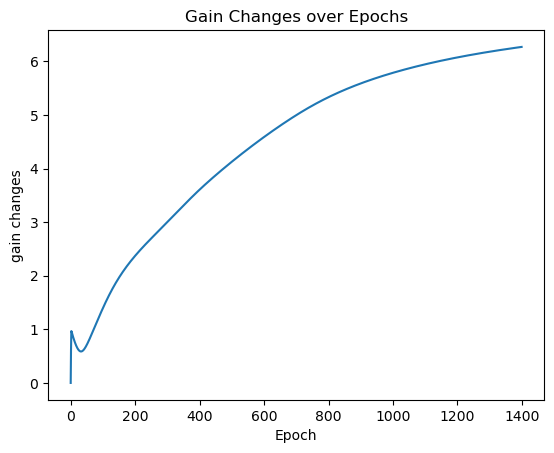

In [36]:
plt.plot(np.arange(len(gain_changes)), gain_changes)
plt.xlabel("Epoch")
plt.ylabel("gain changes")
# plt.ylim([0,0.5])
plt.title("Gain Changes over Epochs")
# plt.savefig("fig/0221_SIN2_bphcppt_gc.png")

Text(0.5, 1.0, 'Shift Changes over Epochs')

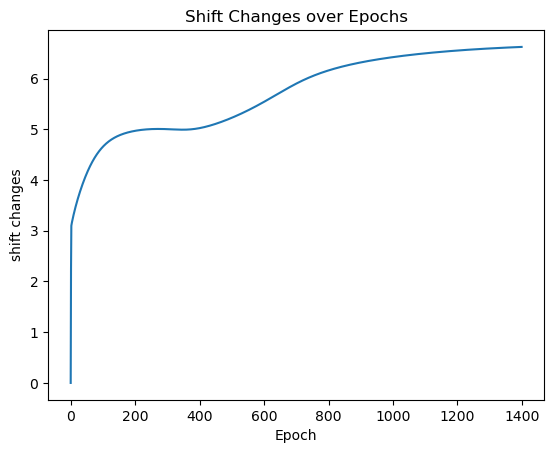

In [37]:
plt.plot(np.arange(len(shift_changes)), shift_changes)
plt.xlabel("Epoch")
plt.ylabel("shift changes")
# plt.ylim([0,0.5])
plt.title("Shift Changes over Epochs")
# plt.savefig("fig/0221_SIN2_bphcppt_sc.png")

In [38]:
first_period_activations = simu_activations[0:120,:,:].squeeze().T
sns.heatmap(first_period_activations, cmap='vlag')
plt.title('Activations')
plt.xlabel('Time')
plt.ylabel('Node')

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

Text(50.722222222222214, 0.5, 'Node')

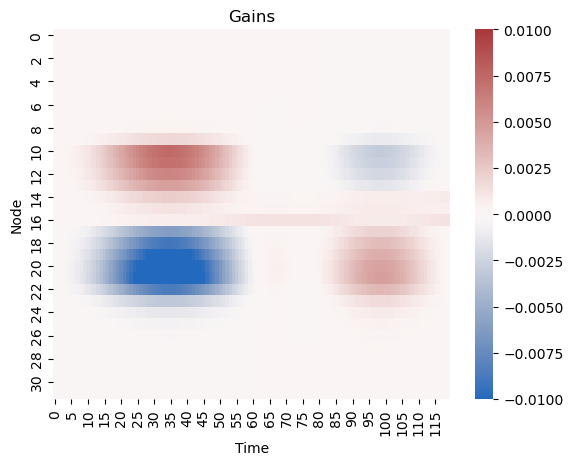

In [88]:
first_period_gains = simu_gains[0:120,:,:].squeeze().T
first_col = first_period_gains[:,0]
first_col_rep = np.tile(first_col, (120,1)).T
first_period_gains_diff = first_period_gains - first_col_rep
sns.heatmap(first_period_gains_diff, cmap='vlag', vmax=0.01, vmin=-0.01)
plt.title('Gains')
plt.xlabel('Time')
plt.ylabel('Node')

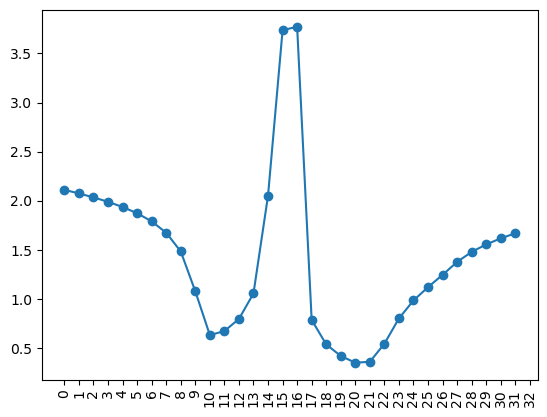

In [85]:
plt.plot(first_col, marker='o')
plt.xticks(np.arange(0, 33), labels=np.arange(0, 33), rotation=90)
plt.show()

Text(50.722222222222214, 0.5, 'Node')

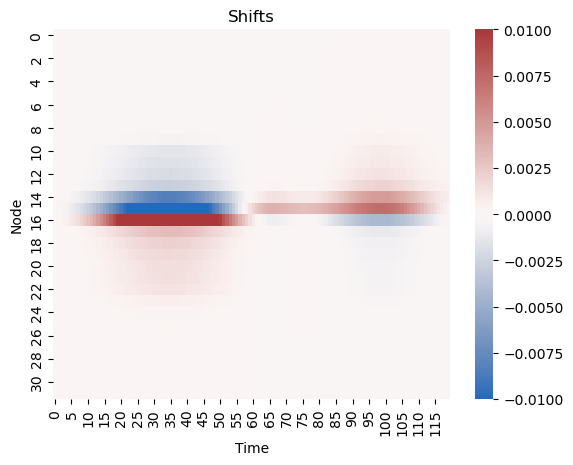

In [89]:
first_period_shifts = simu_shifts[0:120,:,:].squeeze().T
first_col = first_period_shifts[:,0]
first_col_rep = np.tile(first_col, (120,1)).T
first_period_shifts_diff = first_period_shifts - first_col_rep
sns.heatmap(first_period_shifts_diff, cmap='vlag', vmax=0.01, vmin=-0.01)
plt.title('Shifts')
plt.xlabel('Time')
plt.ylabel('Node')

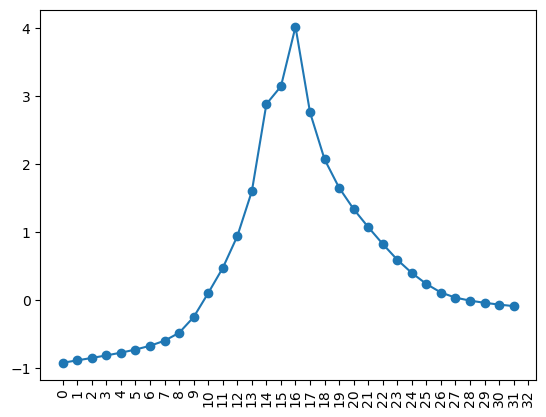

In [90]:
plt.plot(first_col, marker='o')
plt.xticks(np.arange(0, 33), labels=np.arange(0, 33), rotation=90)
plt.show()

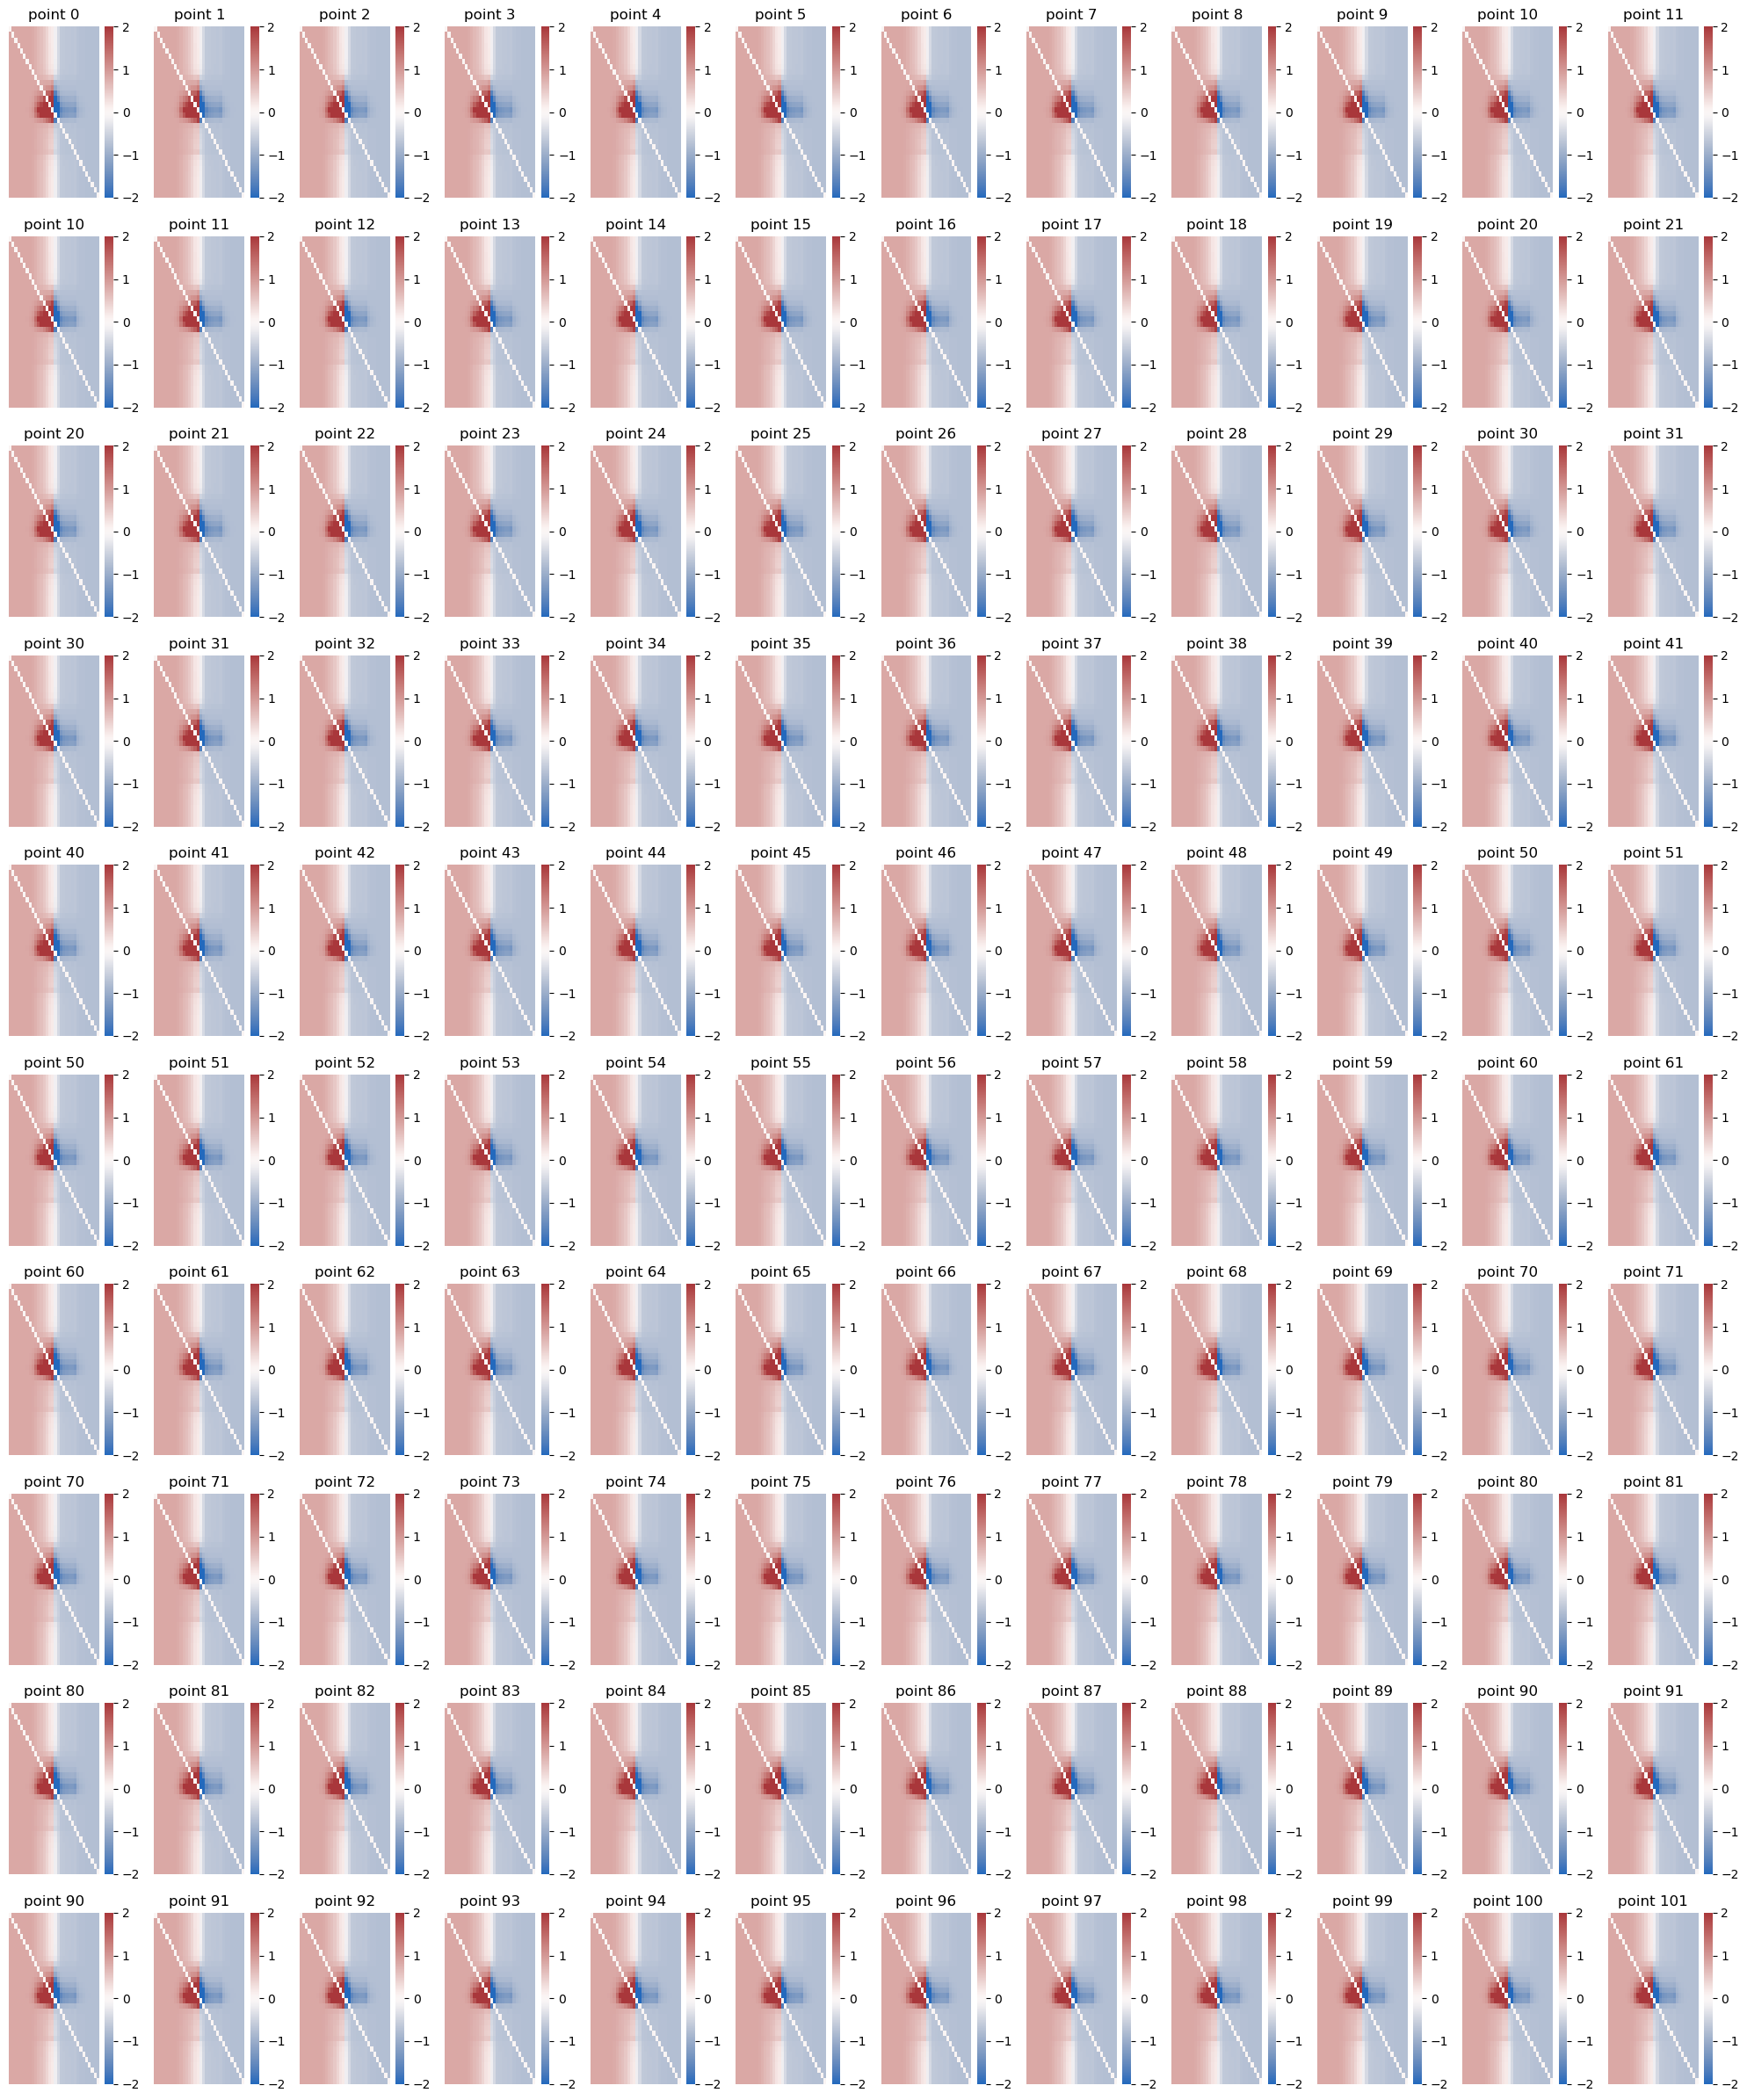

In [18]:
# create a grid of plots showing weight matrix over time
fig, ax = plt.subplots(10, 12, figsize=(20,24))
for i in range(10):
    for j in range(12):
        sns.heatmap(np.array(weights[(i*10+j)]), cmap='vlag', vmax=2, vmin=-2, ax=ax[i, j])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'point {(i*10+j)}')
plt.tight_layout()
# plt.savefig('fig/0221_SIN2_bphcppt_weight_matrix_overtime.png')

### PRVIOUS

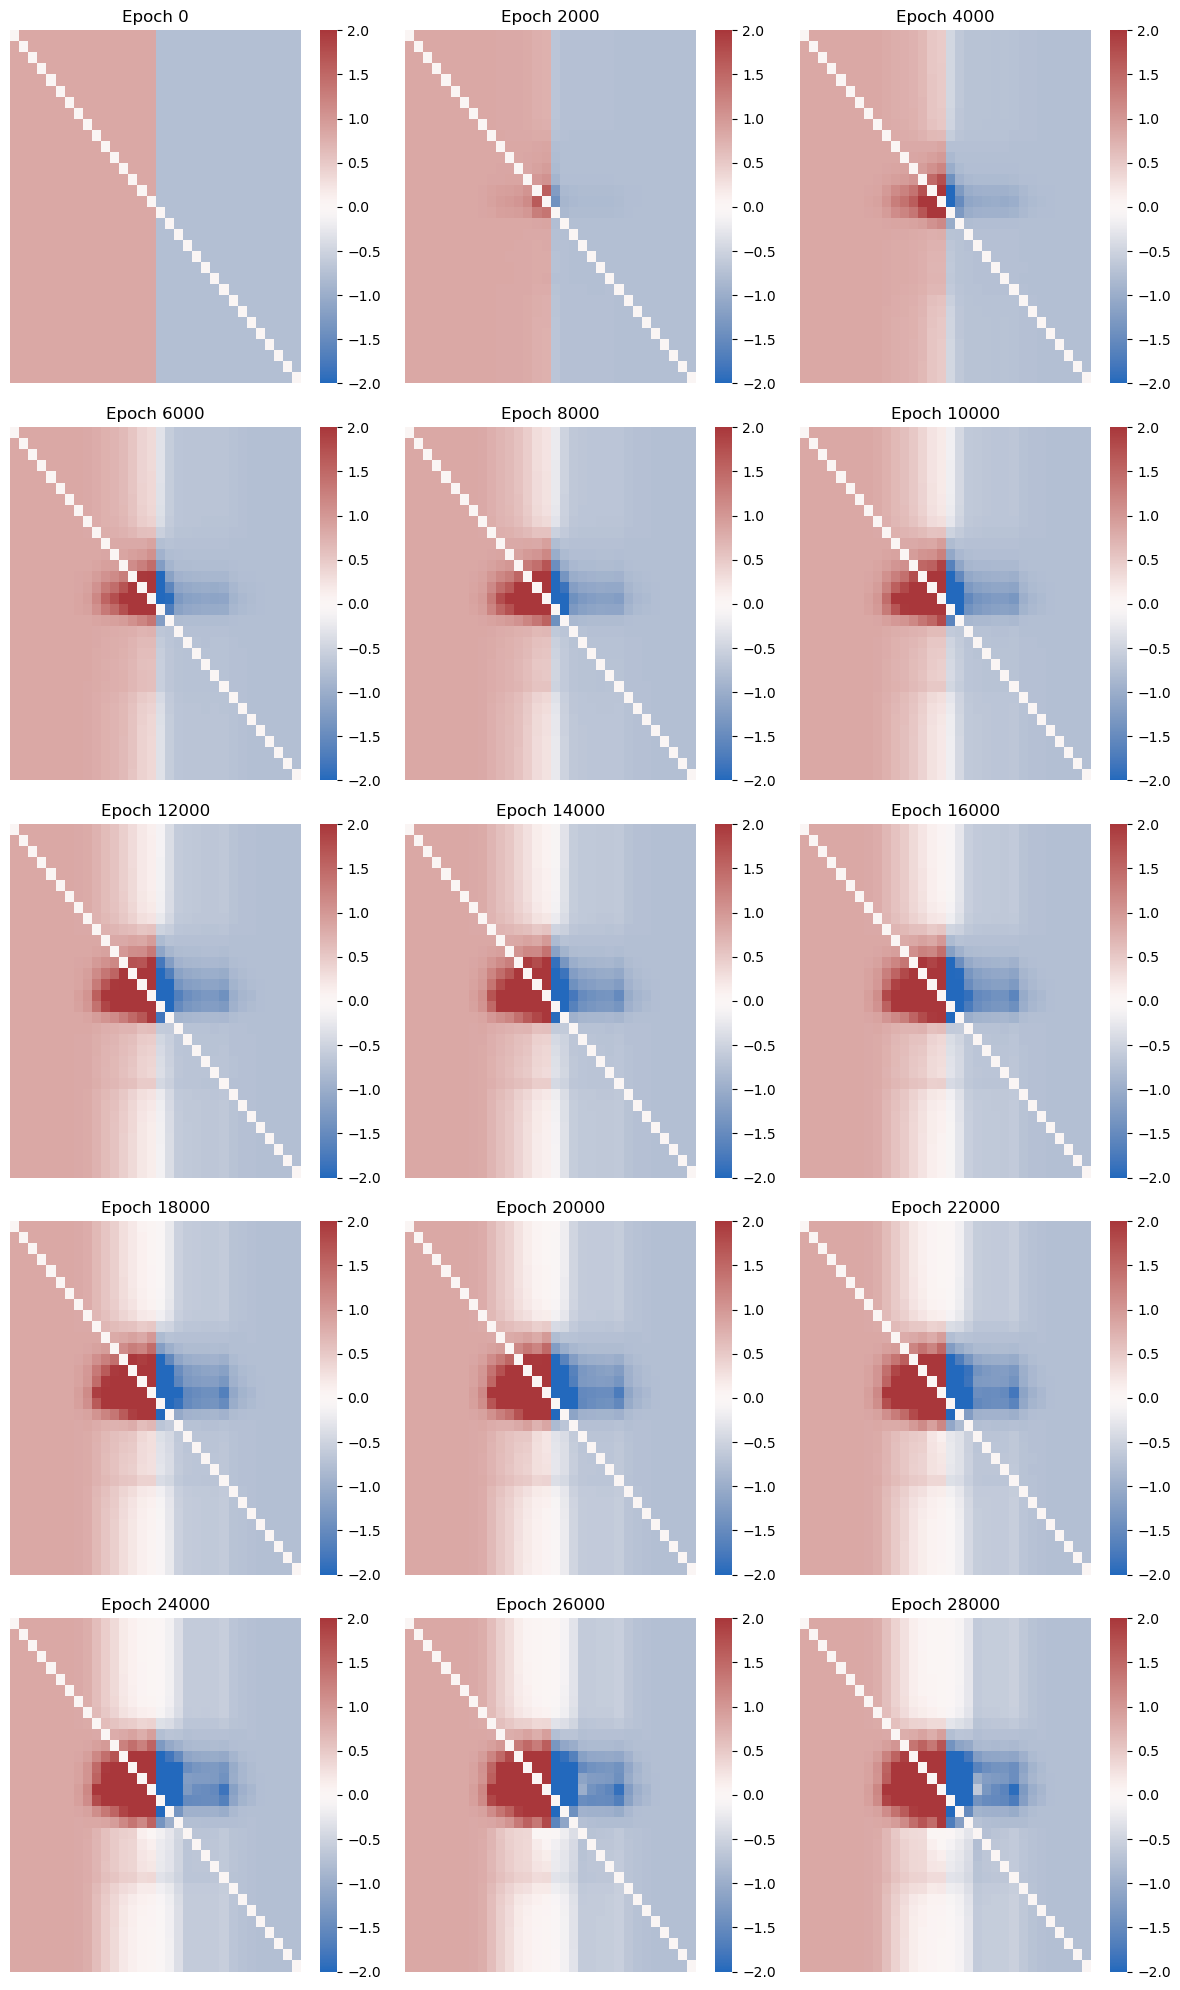

In [50]:
# create a grid of plots showing weight matrix over time
fig, ax = plt.subplots(5, 3, figsize=(12,20))
for i in range(5):
    for j in range(3):
        sns.heatmap(np.array(weights[20*(i*3+j)]), cmap='vlag', vmax=2, vmin=-2, ax=ax[i, j])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'Epoch {2000*(i*3+j)}')
plt.tight_layout()
# plt.savefig('fig/0221_SIN2_bphcppt_weight_matrix_overtime.png')

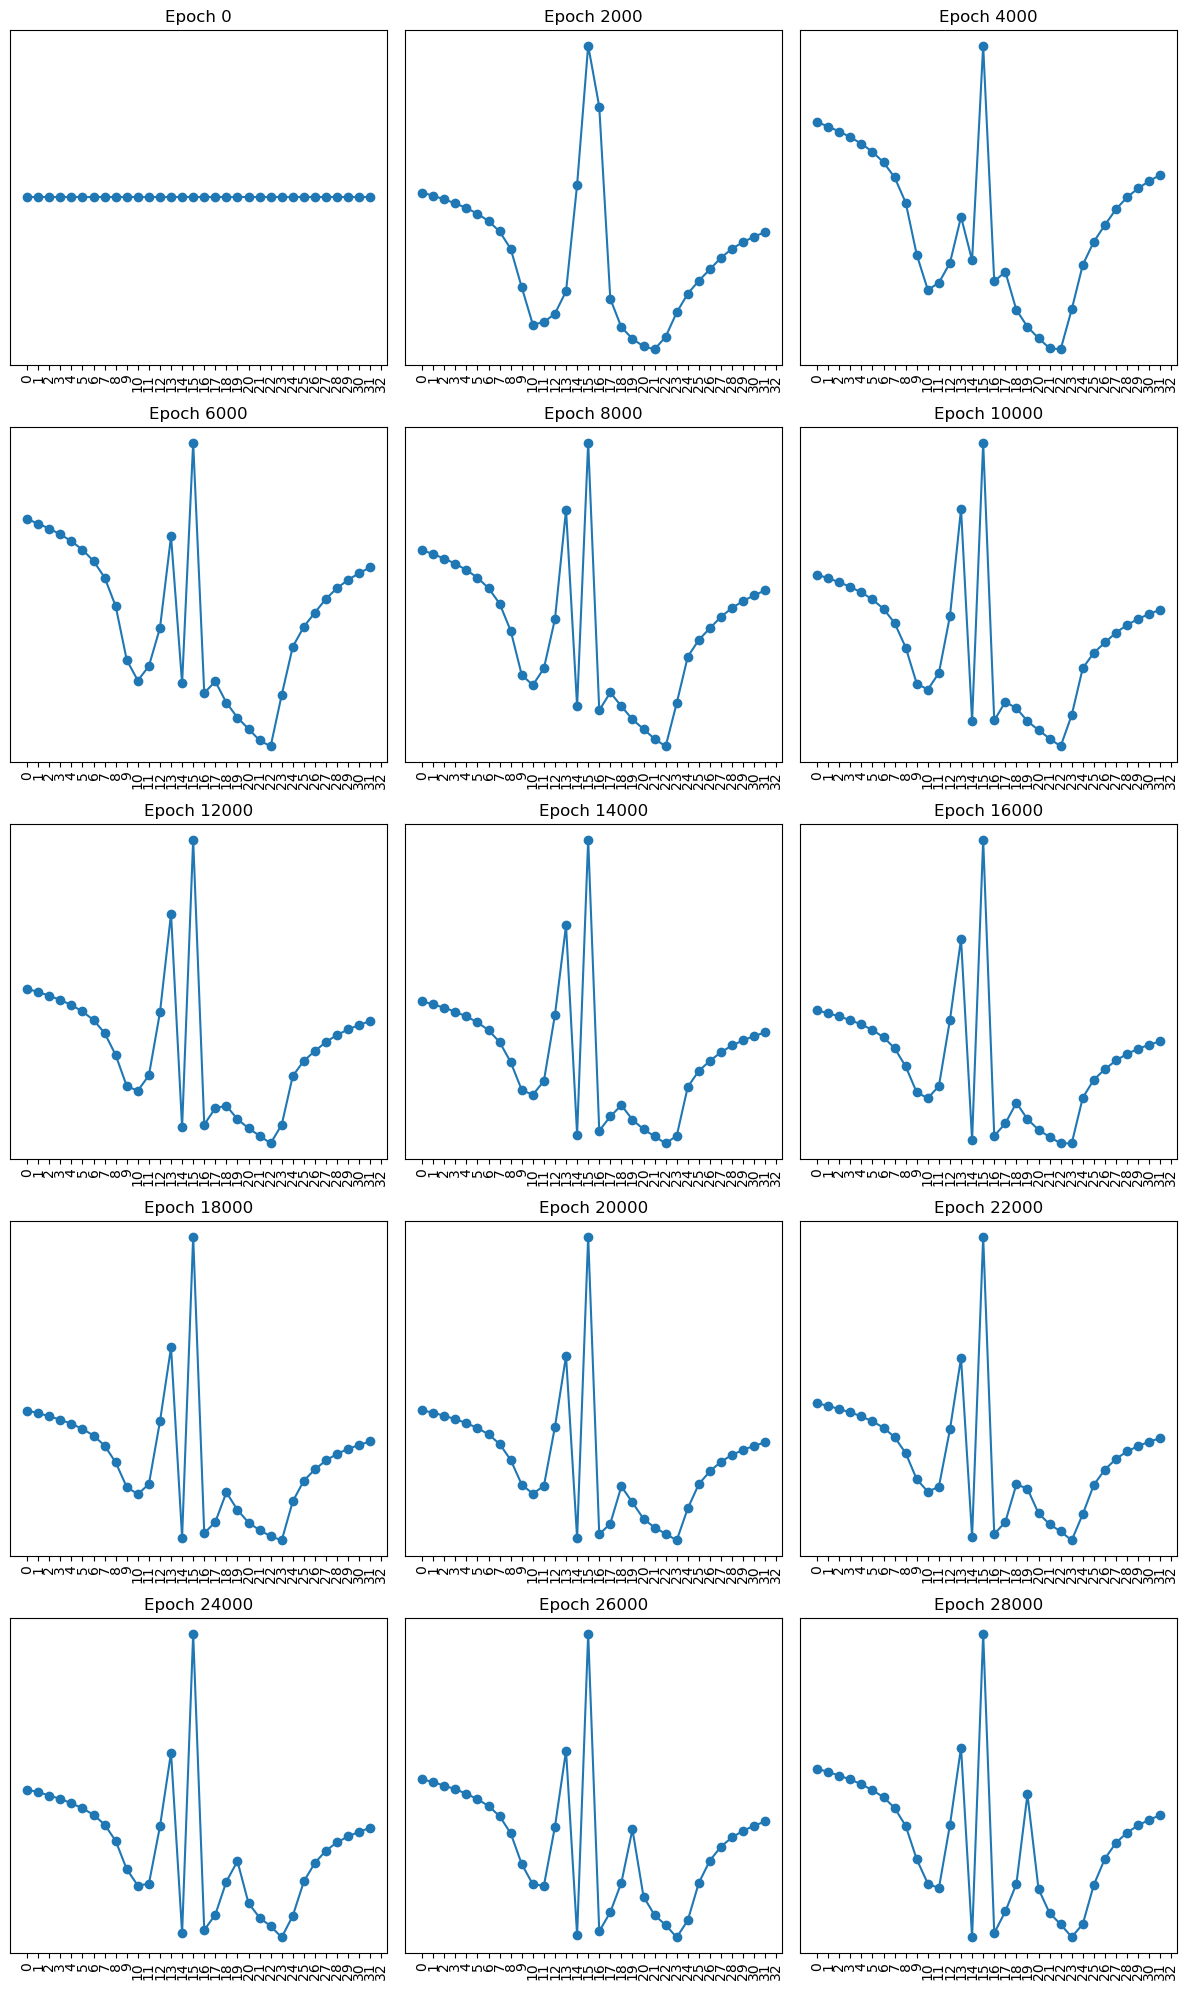

In [61]:
fig, ax = plt.subplots(5, 3, figsize=(12,20))
for i in range(5):
    for j in range(3):
        ax[i, j].plot(np.array(simu_gains[20*(i*3+j)]), marker='o')
        ax[i, j].set_xticks(np.arange(0, 33), labels=np.arange(0, 33), rotation=90)
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'Epoch {2000*(i*3+j)}')
plt.tight_layout()

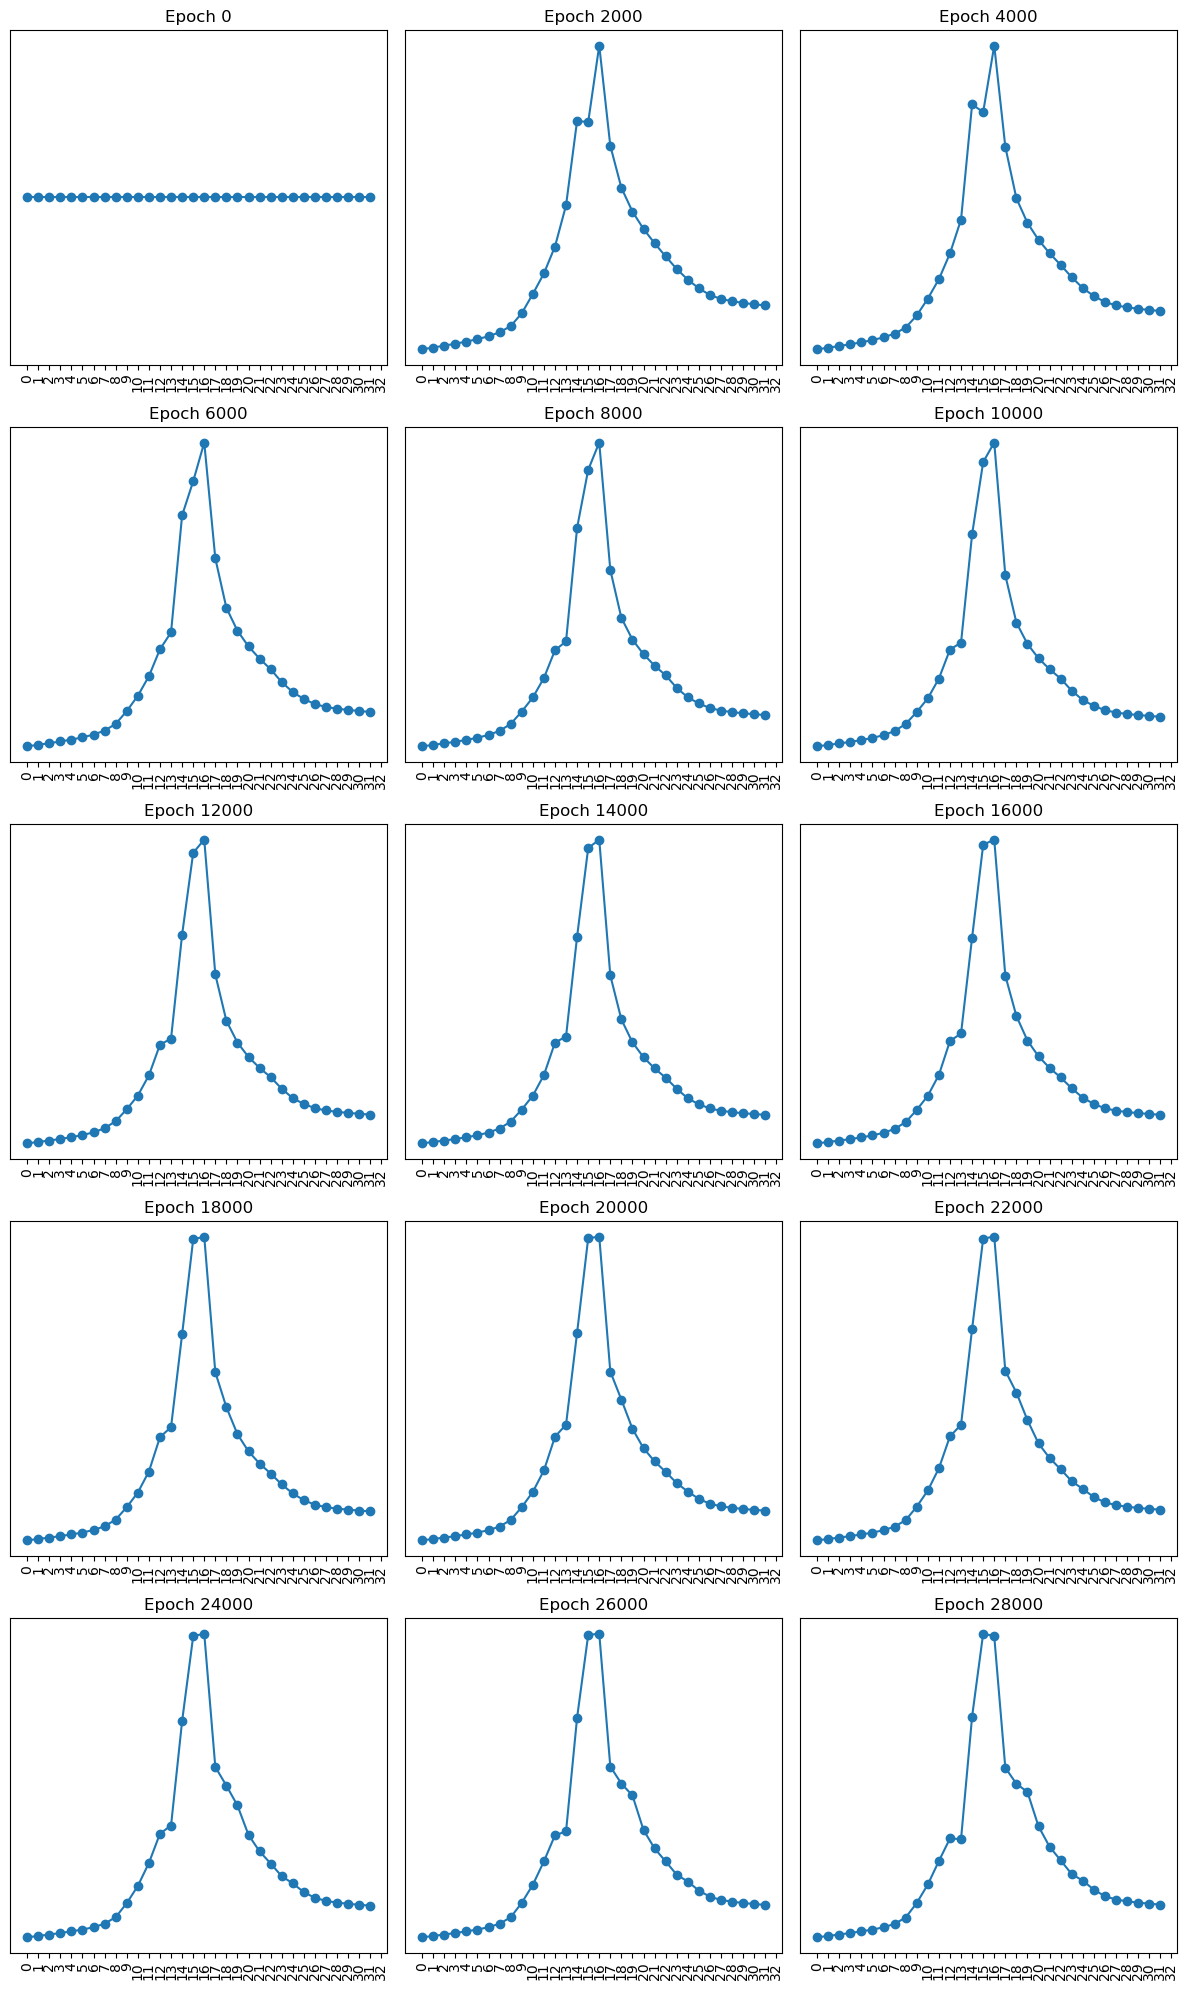

In [62]:
fig, ax = plt.subplots(5, 3, figsize=(12,20))
for i in range(5):
    for j in range(3):
        ax[i, j].plot(np.array(simu_shifts[20*(i*3+j)]), marker='o')
        ax[i, j].set_xticks(np.arange(0, 33), labels=np.arange(0, 33), rotation=90)
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'Epoch {2000*(i*3+j)}')
plt.tight_layout()